# SPOTIFY SONG POPULARITY PREDICTION BASED ON MACHINE LEARNING METHODS

# Neccessary Imports.


In [10]:
# """
# This code was inspired by the following sources:
# - https://github.com/philinyouin/SpotifyPopularityPrediction/blob/main/FinalCapstoneProject_1.ipynb
# - https://github.com/anthonyli358/spotify-recommender-systems
# """

In [1]:
# data processing libraries
import numpy as np
import pandas as pd
# plotting libraries
import matplotlib.pyplot as plt
plt.style.use('ggplot') # Using ggplot2 style visuals 
import seaborn as sns
# preprocessing libraries
from sklearn.preprocessing import RobustScaler
#Scraping Spotify 
from requests.exceptions import ReadTimeout
import spotipy
from spotipy.oauth2 import SpotifyOAuth
# Tokens for my spotify Account.
spotify_token = "fb5047611170475c98cedb3dd91178a9"
spotify_user_id = "04948a0f91444005a8c27c3f3418696d"
# from data_functions import offset_api_limit, get_artists_df, get_tracks_df, get_track_audio_df,\
#     get_all_playlist_tracks_df, get_recommendations
# from outh_secrets import spotify_user_id, spotify_token
import yaml

In [12]:
!mkdir spotify_data

mkdir: cannot create directory ‘spotify_data’: File exists


# Helper Functions to Work on the Data

In [13]:
def offset_api_limit(sp, sp_call):
    """
    Get all (non-limited) artists/tracks from a Spotify API call.
    :param sp: Spotify OAuth
    :param sp_call: API function all
    :return: list of artists/tracks
    """
    results = sp_call
    if 'items' not in results.keys():
        results = results['artists']
    data = results['items']
    while results['next']:
        results = sp.next(results)
        if 'items' not in results.keys():
            results = results['artists']
        data.extend(results['items'])
    return data


def get_artists_df(artists):
    """
    Transform and tidy Spotify artist data
    :param artists: list of Spotify artist data
    :return: formatted pandas dataframe
    """
    artists_df = pd.DataFrame(artists)
    artists_df['followers'] = artists_df['followers'].apply(lambda x: x['total'])
    return artists_df[['id', 'uri', 'type', 'name', 'genres', 'followers']]


def get_tracks_df(tracks):
    """
    Transform and tidy Spotify track data
    :param tracks: list of Spotify track data
    :return: formatted pandas dataframe
    """
    tracks_df = pd.DataFrame(tracks)
    # Spread track values if not yet spread to columns
    if 'track' in tracks_df.columns.tolist():
        tracks_df = tracks_df.drop('track', 1).assign(**tracks_df['track'].apply(pd.Series))
    # Album
    tracks_df['album_id'] = tracks_df['album'].apply(lambda x: x['id'])
    tracks_df['album_name'] = tracks_df['album'].apply(lambda x: x['name'])
    tracks_df['album_release_date'] = tracks_df['album'].apply(lambda x: x['release_date'])
    tracks_df['album_tracks'] = tracks_df['album'].apply(lambda x: x['total_tracks'])
    tracks_df['album_type'] = tracks_df['album'].apply(lambda x: x['type'])
    # Album Artist
    tracks_df['album_artist_id'] = tracks_df['album'].apply(lambda x: x['artists'][0]['id'])
    tracks_df['album_artist_name'] = tracks_df['album'].apply(lambda x: x['artists'][0]['name'])
    # Artist
    tracks_df['artist_id'] = tracks_df['artists'].apply(lambda x: x[0]['id'])
    tracks_df['artist_name'] = tracks_df['artists'].apply(lambda x: x[0]['name'])
    select_columns = ['id', 'name', 'popularity', 'type', 'is_local', 'explicit', 'duration_ms', 'disc_number',
                      'track_number',
                      'artist_id', 'artist_name', 'album_artist_id', 'album_artist_name',
                      'album_id', 'album_name', 'album_release_date', 'album_tracks', 'album_type']
    # saved_tracks has ['added_at', 'tracks']
    if 'added_at' in tracks_df.columns.tolist():
        select_columns.append('added_at')
    return tracks_df[select_columns]


def get_track_audio_df(sp, df):
    """
    Include Spotify audio features and analysis in track data.
    :param sp: Spotify OAuth
    :param df: pandas dataframe of Spotify track data
    :return: formatted pandas dataframe
    """
    df['genres'] = df['artist_id'].apply(lambda x: sp.artist(x)['genres'])
    df['album_genres'] = df['album_artist_id'].apply(lambda x: sp.artist(x)['genres'])
    # Audio features
    df['audio_features'] = df['id'].apply(lambda x: sp.audio_features(x))
    df['audio_features'] = df['audio_features'].apply(pd.Series)
    df = df.drop('audio_features', 1).assign(**df['audio_features'].apply(pd.Series))
    # Don't need sp.audio_analysis(track_id) audio analysis for this project
    return df


def get_all_playlist_tracks_df(sp, sp_call):
    """
    Get all (non-limited) tracks from a Spotify playlist API call
    :param sp:
    :param sp_call:
    :param sp: Spotify OAuth
    :param sp_call: API function all
    :return: list of tracks
    """
    playlists = sp_call
    playlist_data, data = playlists['items'], []
    playlist_ids, playlist_names, playlist_tracks = [], [], []
    # Uncomment this to pull every single saved playlist (commented out here to no blow up data size)
    # while playlists['next']:
    #     playlist_results = sp.next(playlists)
    #     playlist_data.extend(playlist_results['items'])
    for playlist in playlist_data:
        for i in range(playlist['tracks']['total']):
            playlist_ids.append(playlist['id'])
            playlist_names.append(playlist['name'])
            playlist_tracks.append(playlist['tracks']['total'])
        saved_tracks = sp.playlist(playlist['id'], fields="tracks, next")
        results = saved_tracks['tracks']
        data.extend(results['items'])
        while results['next']:
            results = sp.next(results)
            data.extend(results['items'])

    tracks_df = pd.DataFrame(data)
    # Playlists
    tracks_df['playlist_id'] = playlist_ids
    tracks_df['playlist_name'] = playlist_names
    tracks_df['playlist_tracks'] = playlist_tracks
    # Dataframe manipulation
    tracks_df = tracks_df[tracks_df['is_local'] == False]  # remove local tracks (no audio data)
    tracks_df = tracks_df.drop('track', 1).assign(**tracks_df['track'].apply(pd.Series))
    # Album
    tracks_df['album_id'] = tracks_df['album'].apply(lambda x: x['id'])
    tracks_df['album_name'] = tracks_df['album'].apply(lambda x: x['name'])
    tracks_df['album_release_date'] = tracks_df['album'].apply(lambda x: x['release_date'])
    tracks_df['album_tracks'] = tracks_df['album'].apply(lambda x: x['total_tracks'])
    tracks_df['album_type'] = tracks_df['album'].apply(lambda x: x['type'])
    # Album Artist
    tracks_df['album_artist_id'] = tracks_df['album'].apply(lambda x: x['artists'][0]['id'])
    tracks_df['album_artist_name'] = tracks_df['album'].apply(lambda x: x['artists'][0]['name'])
    # Artist
    tracks_df['artist_id'] = tracks_df['artists'].apply(lambda x: x[0]['id'])
    tracks_df['artist_name'] = tracks_df['artists'].apply(lambda x: x[0]['name'])
    # playlist_tracks has ['added_at', 'added_by', 'is_local', 'primary_color', 'track', 'video_thumbnail']
    select_columns = ['id', 'name', 'popularity', 'type', 'is_local', 'explicit', 'duration_ms', 'disc_number',
                      'track_number',
                      'artist_id', 'artist_name', 'album_artist_id', 'album_artist_name',
                      'album_id', 'album_name', 'album_release_date', 'album_tracks', 'album_type',
                      'playlist_id', 'playlist_name', 'playlist_tracks',
                      'added_at', 'added_by']
    return tracks_df[select_columns]


def get_recommendations(sp, tracks):
    """
    Get recommendations from a list of Spotify track ids.
    :param sp: Spotify OAuth
    :param tracks: list of Spotify track ids
    :return: list of tracks
    """
    data = []
    for x in tracks:
        results = sp.recommendations(seed_tracks=[x])  # default api limit of 20 is enough
        data.extend(results['tracks'])
    return data

# Data Importing.
- Acquire Data by scraping it from spotify using spotipy package.
- Save the data as a pickle files so that it can quickly be read by multiple workflows.

In [14]:
# scope = "user-library-read user-follow-read user-top-read playlist-read-private"

# sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
#     client_id=spotify_user_id,
#     client_secret=spotify_token,
#     redirect_uri="http://localhost:9002/callback",
#     scope=scope
# ), requests_timeout=180)
# # Spotify API calls and data manipulation
# # Save for later to be quickly read by multiple workflows
# print("Getting, transforming, and saving top artist data...")
# top_artists = offset_api_limit(sp, sp.current_user_top_artists())
# top_artists_df = get_artists_df(top_artists)
# top_artists_df.to_pickle("spotify_data/top_artists.pkl")

# print("Getting, transforming, and saving followed artist data...")
# followed_artists = offset_api_limit(sp, sp.current_user_followed_artists())
# followed_artists_df = get_artists_df(followed_artists)
# followed_artists_df.to_pickle("spotify_data/followed_artists.pkl")

# print("Getting, transforming, and saving top track data...")
# top_tracks = offset_api_limit(sp, sp.current_user_top_tracks())
# top_tracks_df = get_tracks_df(top_tracks)
# top_tracks_df = get_track_audio_df(sp, top_tracks_df)
# top_tracks_df.to_pickle("spotify_data/top_tracks.pkl")

# print("Getting, transforming, and saving saved track data...")
# saved_tracks = offset_api_limit(sp, sp.current_user_saved_tracks())
# saved_tracks_df = get_tracks_df(saved_tracks)
# saved_tracks_df = get_track_audio_df(sp, saved_tracks_df)
# saved_tracks_df.to_pickle("spotify_data/saved_tracks.pkl")


In [15]:
# print("Getting, transforming, and saving playlist track data...")
# playlist_tracks_df = get_all_playlist_tracks_df(sp, sp.current_user_playlists())  # limit of 50 playlists by default
# # remove a non existing Id from the playlists
# playlist_tracks_df = playlist_tracks_df[playlist_tracks_df.artist_id != "0Y7IrnvAReGx0hl1GVBjTu"]
# playlist_tracks_df = get_track_audio_df(sp, playlist_tracks_df)
# playlist_tracks_df.to_pickle("spotify_data/playlist_tracks.pkl")

In [16]:
# # Create yaml dump
# playlist_dict = dict(zip(playlist_tracks_df['playlist_name'], playlist_tracks_df['playlist_id']))
# with open('spotify_data/playlists.yml', 'w') as outfile:
#     yaml.dump(playlist_dict, outfile, default_flow_style=False)

# print("Getting, transforming, and saving tracks recommendations...")
# # Define a sample playlists to yield tracks to get recommendations for, 20 recommendations per track
# recommendation_tracks = get_recommendations(sp, playlist_tracks_df[playlist_tracks_df['playlist_name'].isin(
#     ["Chill", "Chill '20", "Chill '19", "Chill '18", "Your Top Songs 2020", "Your Top Songs 2019", "Your Top Songs 2018"
#      ])].drop_duplicates(subset='id', keep="first")['id'].tolist())
# recommendation_tracks_df = get_tracks_df(recommendation_tracks)
# # recommendation_tracks_df = get_track_audio_df(sp, recommendation_tracks_df)
# recommendation_tracks_df.to_pickle("spotify_data/recommendation_tracks.pkl")

In [2]:
top_artist_df = pd.read_pickle("spotify_data/top_artists.pkl")
followed_artists_df = pd.read_pickle("spotify_data/followed_artists.pkl")
top_tracks_df = pd.read_pickle("spotify_data/top_tracks.pkl")
saved_tracks_df = pd.read_pickle("spotify_data/saved_tracks.pkl")
playlist_tracks_df = pd.read_pickle("spotify_data/playlist_tracks.pkl")
recommendation_tracks_df = pd.read_pickle("spotify_data/recommendation_tracks.pkl")

In [3]:
playlist_tracks_df['popularity'] = playlist_tracks_df['popularity'] / 100  # normalise popularity feature between 0 and 1
playlist_tracks_df.head()

,id,name,popularity,type,is_local,explicit,duration_ms,disc_number,track_number,artist_id,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature
3,5eattTP6wBD7BN8KtKt7gO,Güya,0.50,audio_features,False,False,179651,1,1,3WKZeiNOV5dnANlQnjL95B,...,0.2120,0.279,0.000024,0.066,0.733,171.936,spotify:track:5eattTP6wBD7BN8KtKt7gO,https://api.spotify.com/v1/tracks/5eattTP6wBD7...,https://api.spotify.com/v1/audio-analysis/5eat...,4
4,7tQzRtcodzeVr6n0DdVHCe,Toparlanmam Lazım,0.48,audio_features,False,False,195692,1,1,2xNgzwX6A9orF0QEJph5Eb,...,0.0392,0.709,0.000031,0.153,0.371,129.909,spotify:track:7tQzRtcodzeVr6n0DdVHCe,https://api.spotify.com/v1/tracks/7tQzRtcodzeV...,https://api.spotify.com/v1/audio-analysis/7tQz...,4
5,12Df1GI1bZGHG5l0PvvxRc,Gün Ağarmadan,0.44,audio_features,False,False,195375,1,1,3cNwyF5SboOs9icz2XyotE,...,0.0548,0.283,0.000000,0.276,0.151,159.707,spotify:track:12Df1GI1bZGHG5l0PvvxRc,https://api.spotify.com/v1/tracks/12Df1GI1bZGH...,https://api.spotify.com/v1/audio-analysis/12Df...,4
6,7aI1YkyFmJtB2OvI1dF2o7,RRAK TAK TAK - Remix,0.29,audio_features,False,False,149677,1,1,07eC5PcqS4O5e6NX1mrSCZ,...,0.0484,0.102,0.440000,0.165,0.613,92.990,spotify:track:7aI1YkyFmJtB2OvI1dF2o7,https://api.spotify.com/v1/tracks/7aI1YkyFmJtB...,https://api.spotify.com/v1/audio-analysis/7aI1...,4
7,1RMnFV3jidSADH1ZSF8EAr,Nereden Bileceksiniz,0.63,audio_features,False,False,360327,1,3,1Y2FwScblyMxpLTrNdfwyU,...,0.0348,0.747,0.000058,0.130,0.512,108.973,spotify:track:1RMnFV3jidSADH1ZSF8EAr,https://api.spotify.com/v1/tracks/1RMnFV3jidSA...,https://api.spotify.com/v1/audio-analysis/1RMn...,4


# Data Cleaning.
- Removing duplicates
- Avoiding Data leakages.

In [4]:
# Remove duplicates on track id
playlist_tracks_df = playlist_tracks_df.drop_duplicates(subset='id', keep="first").reset_index()
recommendation_tracks_df = recommendation_tracks_df.drop_duplicates(subset='id', keep="first").reset_index()
# Avoid data leakage
recommendation_tracks_df = recommendation_tracks_df[~recommendation_tracks_df['id'].isin(playlist_tracks_df['id'].tolist())]

# Create Ratings from the Popularity Column
The three ratings will come from the popularity column.
Three groupings, i.e., low, medium and high will be created from the popularity index. 
This may later be used for classification tasks.

In [5]:
pd.cut(playlist_tracks_df['popularity'], bins=3)

0           (0.33, 0.66]
1           (0.33, 0.66]
2           (0.33, 0.66]
3       (-0.00099, 0.33]
4           (0.33, 0.66]
              ...       
1917        (0.33, 0.66]
1918        (0.33, 0.66]
1919    (-0.00099, 0.33]
1920        (0.66, 0.99]
1921        (0.33, 0.66]
Name: popularity, Length: 1922, dtype: category
Categories (3, interval[float64]): [(-0.00099, 0.33] < (0.33, 0.66] < (0.66, 0.99]]

In [6]:
pd.cut(playlist_tracks_df['popularity'], bins=3, labels = ["low", "medium", "high"]).value_counts()

medium    1161
low        415
high       346
Name: popularity, dtype: int64

In [7]:
playlist_tracks_df['ratings'] = pd.cut(playlist_tracks_df.popularity, bins=3, labels = ["low", "medium", "high"], right = True)
playlist_tracks_df['ratings']

0       medium
1       medium
2       medium
3          low
4       medium
         ...  
1917    medium
1918    medium
1919       low
1920      high
1921    medium
Name: ratings, Length: 1922, dtype: category
Categories (3, object): ['low' < 'medium' < 'high']

In [8]:
playlist_tracks_df.loc[playlist_tracks_df['ratings']== 'high']

,index,id,name,popularity,type,is_local,explicit,duration_ms,disc_number,track_number,...,acousticness,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature,ratings
56,59,3lJOIGsFylH947nMpYzfGO,Alaz Alaz,0.68,audio_features,False,False,179271,1,5,...,0.72100,0.000000,0.4060,0.6440,114.022,spotify:track:3lJOIGsFylH947nMpYzfGO,https://api.spotify.com/v1/tracks/3lJOIGsFylH9...,https://api.spotify.com/v1/audio-analysis/3lJO...,4,high
104,107,4saklk6nie3yiGePpBwUoc,Dynamite,0.83,audio_features,False,False,199054,1,8,...,0.01120,0.000000,0.0936,0.7370,114.044,spotify:track:4saklk6nie3yiGePpBwUoc,https://api.spotify.com/v1/tracks/4saklk6nie3y...,https://api.spotify.com/v1/audio-analysis/4sak...,4,high
105,108,3FeVmId7tL5YN8B7R3imoM,My Universe,0.94,audio_features,False,False,228000,1,1,...,0.00813,0.000000,0.2000,0.4430,104.988,spotify:track:3FeVmId7tL5YN8B7R3imoM,https://api.spotify.com/v1/tracks/3FeVmId7tL5Y...,https://api.spotify.com/v1/audio-analysis/3FeV...,4,high
111,114,3Dgmyz32dxvtxvUTPS0CUI,Vivaldi Variation (Arr. for Piano from Concert...,0.67,audio_features,False,False,112353,1,1,...,0.95700,0.893000,0.1150,0.0972,78.809,spotify:track:3Dgmyz32dxvtxvUTPS0CUI,https://api.spotify.com/v1/tracks/3Dgmyz32dxvt...,https://api.spotify.com/v1/audio-analysis/3Dgm...,1,high
163,166,3xr8COed4nPPn6XWZ0iCGr,River Flows in You,0.67,audio_features,False,False,218293,1,2,...,0.96800,0.978000,0.0900,0.3460,145.703,spotify:track:3xr8COed4nPPn6XWZ0iCGr,https://api.spotify.com/v1/tracks/3xr8COed4nPP...,https://api.spotify.com/v1/audio-analysis/3xr8...,4,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812,1877,2sLS4tVaEoMYrNS67PVz0V,She Will Be Loved - Acoustic,0.70,audio_features,False,False,276787,1,3,...,0.49600,0.000005,0.6980,0.5800,98.120,spotify:track:2sLS4tVaEoMYrNS67PVz0V,https://api.spotify.com/v1/tracks/2sLS4tVaEoMY...,https://api.spotify.com/v1/audio-analysis/2sLS...,4,high
1891,1957,359lSGQwvAM3aZA5UNwqiQ,If You Ever Wanna Be In Love - James Bay Spoti...,0.67,audio_features,False,False,236787,1,3,...,0.91300,0.000000,0.7120,0.3610,117.614,spotify:track:359lSGQwvAM3aZA5UNwqiQ,https://api.spotify.com/v1/tracks/359lSGQwvAM3...,https://api.spotify.com/v1/audio-analysis/359l...,4,high
1893,1959,0UN0qSJUnWWvIOgv3nYY2A,Barbar,0.71,audio_features,False,False,180606,1,1,...,0.25800,0.097800,0.1280,0.7950,99.017,spotify:track:0UN0qSJUnWWvIOgv3nYY2A,https://api.spotify.com/v1/tracks/0UN0qSJUnWWv...,https://api.spotify.com/v1/audio-analysis/0UN0...,4,high
1914,1980,0EH7sgeiFqDa3eS7ieW2zs,Chammak Challo,0.68,audio_features,False,False,227091,1,1,...,0.06960,0.000007,0.0981,0.9360,133.946,spotify:track:0EH7sgeiFqDa3eS7ieW2zs,https://api.spotify.com/v1/tracks/0EH7sgeiFqDa...,https://api.spotify.com/v1/audio-analysis/0EH7...,4,high


### Get the propotion of each of the 3 ratings.


In [9]:
y = playlist_tracks_df.ratings
y.value_counts()/y.count()

medium    0.604058
low       0.215921
high      0.180021
Name: ratings, dtype: float64

In [10]:
playlist_tracks_df.shape

(1922, 42)

There are 1924 observations with 42 variables. The name of the variables are as shown below.

In [11]:
playlist_tracks_df.columns

Index(['index', 'id', 'name', 'popularity', 'type', 'is_local', 'explicit',
       'duration_ms', 'disc_number', 'track_number', 'artist_id',
       'artist_name', 'album_artist_id', 'album_artist_name', 'album_id',
       'album_name', 'album_release_date', 'album_tracks', 'album_type',
       'playlist_id', 'playlist_name', 'playlist_tracks', 'added_at',
       'added_by', 'genres', 'album_genres', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'uri', 'track_href', 'analysis_url',
       'time_signature', 'ratings'],
      dtype='object')

The default datatypes for each of the columns are as shown below.

In [12]:
pd.DataFrame(playlist_tracks_df.dtypes, columns=['DataType'])

,DataType
index,int64
id,object
name,object
popularity,float64
type,object
is_local,bool
explicit,bool
duration_ms,int64
disc_number,int64
track_number,int64


Let's look at a short description of the numerical features in the popularity dataset.

In [13]:
playlist_tracks_df[['popularity','duration_ms', 'disc_number', 'track_number', 'album_tracks', 'playlist_tracks']].describe()

,popularity,duration_ms,disc_number,track_number,album_tracks,playlist_tracks
count,1922.000000,1.922000e+03,1922.000000,1922.000000,1922.000000,1922.000000
mean,0.459740,2.349169e+05,1.026535,3.710718,9.067118,165.259625
std,0.231597,8.951530e+04,0.345753,4.086847,11.456191,100.053373
min,0.000000,4.286700e+04,1.000000,1.000000,1.000000,4.000000
25%,0.360000,1.912592e+05,1.000000,1.000000,1.000000,100.000000
50%,0.490000,2.221830e+05,1.000000,2.000000,9.000000,126.000000
75%,0.620000,2.586090e+05,1.000000,5.000000,13.000000,300.000000
max,0.990000,1.581680e+06,11.000000,43.000000,204.000000,300.000000


In [14]:
playlist_tracks_df.added_at.nunique()

380

In [15]:
playlist_tracks_df.popularity.unique()

array([0.5 , 0.48, 0.44, 0.29, 0.63, 0.62, 0.56, 0.6 , 0.54, 0.52, 0.47,
       0.45, 0.59, 0.13, 0.53, 0.4 , 0.43, 0.39, 0.38, 0.18, 0.64, 0.58,
       0.51, 0.  , 0.57, 0.49, 0.42, 0.68, 0.46, 0.34, 0.41, 0.35, 0.25,
       0.55, 0.19, 0.65, 0.3 , 0.83, 0.94, 0.07, 0.67, 0.27, 0.21, 0.22,
       0.24, 0.37, 0.33, 0.08, 0.32, 0.71, 0.2 , 0.36, 0.1 , 0.16, 0.31,
       0.66, 0.17, 0.61, 0.72, 0.69, 0.75, 0.06, 0.77, 0.88, 0.12, 0.14,
       0.23, 0.01, 0.79, 0.28, 0.7 , 0.73, 0.76, 0.26, 0.04, 0.82, 0.8 ,
       0.78, 0.86, 0.74, 0.99, 0.03, 0.84, 0.02, 0.81, 0.89, 0.87, 0.05,
       0.85, 0.09, 0.15])

In [16]:
playlist_tracks_df.sort_values(by='popularity', ascending=False).head(12)


,index,id,name,popularity,type,is_local,explicit,duration_ms,disc_number,track_number,...,acousticness,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature,ratings
952,980,4fouWK6XVHhzl78KzQ1UjL,abcdefu,0.99,audio_features,False,True,168602,1,1,...,0.29900,0.000000,0.3670,0.4150,121.932,spotify:track:4fouWK6XVHhzl78KzQ1UjL,https://api.spotify.com/v1/tracks/4fouWK6XVHhz...,https://api.spotify.com/v1/audio-analysis/4fou...,4,high
496,499,3uUuGVFu1V7jTQL60S1r8z,Where Are You Now,0.94,audio_features,False,False,148197,1,1,...,0.51500,0.000411,0.1720,0.2620,120.966,spotify:track:3uUuGVFu1V7jTQL60S1r8z,https://api.spotify.com/v1/tracks/3uUuGVFu1V7j...,https://api.spotify.com/v1/audio-analysis/3uUu...,4,high
105,108,3FeVmId7tL5YN8B7R3imoM,My Universe,0.94,audio_features,False,False,228000,1,1,...,0.00813,0.000000,0.2000,0.4430,104.988,spotify:track:3FeVmId7tL5YN8B7R3imoM,https://api.spotify.com/v1/tracks/3FeVmId7tL5Y...,https://api.spotify.com/v1/audio-analysis/3FeV...,4,high
989,1017,0tgVpDi06FyKpA1z0VMD4v,Perfect,0.89,audio_features,False,False,263400,1,5,...,0.16300,0.000000,0.1060,0.1680,95.050,spotify:track:0tgVpDi06FyKpA1z0VMD4v,https://api.spotify.com/v1/tracks/0tgVpDi06FyK...,https://api.spotify.com/v1/audio-analysis/0tgV...,3,high
988,1016,21jGcNKet2qwijlDFuPiPb,Circles,0.89,audio_features,False,False,215280,1,6,...,0.19200,0.002440,0.0863,0.5530,120.042,spotify:track:21jGcNKet2qwijlDFuPiPb,https://api.spotify.com/v1/tracks/21jGcNKet2qw...,https://api.spotify.com/v1/audio-analysis/21jG...,4,high
970,998,7qEHsqek33rTcFNT9PFqLf,Someone You Loved,0.89,audio_features,False,False,182161,1,4,...,0.75100,0.000000,0.1050,0.4460,109.891,spotify:track:7qEHsqek33rTcFNT9PFqLf,https://api.spotify.com/v1/tracks/7qEHsqek33rT...,https://api.spotify.com/v1/audio-analysis/7qEH...,4,high
1032,1060,3U4isOIWM3VvDubwSI3y7a,All of Me,0.88,audio_features,False,False,269560,1,6,...,0.92200,0.000000,0.1320,0.3310,119.930,spotify:track:3U4isOIWM3VvDubwSI3y7a,https://api.spotify.com/v1/tracks/3U4isOIWM3Vv...,https://api.spotify.com/v1/audio-analysis/3U4i...,4,high
1492,1543,5JCoSi02qi3jJeHdZXMmR8,favorite crime,0.88,audio_features,False,False,152667,1,10,...,0.86600,0.000000,0.1470,0.2180,172.929,spotify:track:5JCoSi02qi3jJeHdZXMmR8,https://api.spotify.com/v1/tracks/5JCoSi02qi3j...,https://api.spotify.com/v1/audio-analysis/5JCo...,4,high
435,438,3AJwUDP919kvQ9QcozQPxg,Yellow,0.88,audio_features,False,False,266773,1,5,...,0.00239,0.000121,0.2340,0.2850,173.372,spotify:track:3AJwUDP919kvQ9QcozQPxg,https://api.spotify.com/v1/tracks/3AJwUDP919kv...,https://api.spotify.com/v1/audio-analysis/3AJw...,4,high
451,454,086myS9r57YsLbJpU0TgK9,Why'd You Only Call Me When You're High?,0.88,audio_features,False,False,161124,1,9,...,0.04830,0.000011,0.1040,0.8000,92.004,spotify:track:086myS9r57YsLbJpU0TgK9,https://api.spotify.com/v1/tracks/086myS9r57Ys...,https://api.spotify.com/v1/audio-analysis/086m...,4,high


## Bivariate Analysis

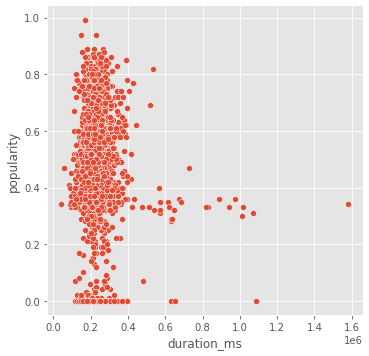

In [ ]:
sns.relplot(x="duration_ms", y="popularity", data=playlist_tracks_df);

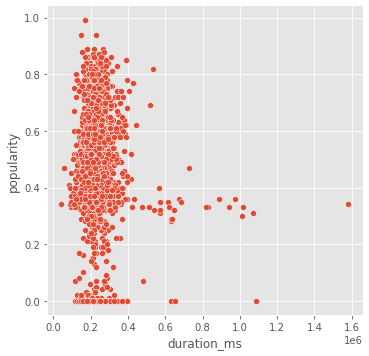

In [ ]:
sns.relplot(x="duration_ms", y="popularity", data=playlist_tracks_df);

In [17]:
null_data = playlist_tracks_df[playlist_tracks_df.isnull().any(axis=1)]
print(null_data)

Empty DataFrame
Columns: [index, id, name, popularity, type, is_local, explicit, duration_ms, disc_number, track_number, artist_id, artist_name, album_artist_id, album_artist_name, album_id, album_name, album_release_date, album_tracks, album_type, playlist_id, playlist_name, playlist_tracks, added_at, added_by, genres, album_genres, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, uri, track_href, analysis_url, time_signature, ratings]
Index: []

[0 rows x 42 columns]


No existance of null values

In [18]:
playlist_tracks_df.dropna(inplace = True)

In [19]:
playlist_tracks_df.drop("is_local", axis = 1, inplace=True)

/home/rohi/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


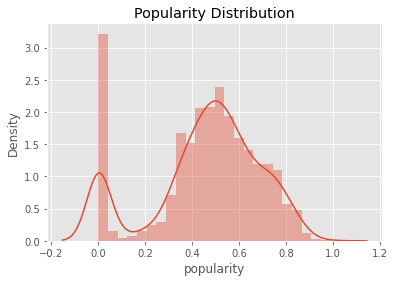

In [20]:
sns.distplot(playlist_tracks_df['popularity']).set_title('Popularity Distribution');


In [ ]:
playlist_tracks_df.corr()

,index,popularity,explicit,duration_ms,disc_number,track_number,album_tracks,playlist_tracks,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
index,1.000000,-0.014391,0.044799,-0.022394,-0.036434,-0.036457,-0.090293,0.098164,0.256266,0.184024,0.005391,0.435077,0.207544,-0.058575,-0.148528,-0.551761,0.023041,0.223110,0.067343,0.127552
popularity,-0.014391,1.000000,0.055442,-0.071960,-0.026047,-0.027392,-0.016513,-0.022824,0.091119,0.138534,0.000873,0.129533,0.039574,-0.027398,-0.128003,-0.075004,0.001743,0.066426,0.039458,0.027106
explicit,0.044799,0.055442,1.000000,-0.057971,-0.014247,-0.034413,-0.041093,-0.078323,0.157295,0.088079,0.030584,0.093849,-0.006957,0.150142,-0.107891,-0.087844,0.009273,0.061958,0.017942,0.005864
duration_ms,-0.022394,-0.071960,-0.057971,1.000000,-0.000046,0.054052,0.065119,-0.222290,-0.128639,-0.029093,-0.016037,-0.096347,0.026540,0.284825,-0.126256,-0.110635,0.058748,-0.091133,-0.047707,-0.042260
disc_number,-0.036434,-0.026047,-0.014247,-0.000046,1.000000,0.053327,0.616311,0.035299,-0.025953,-0.045417,-0.000023,-0.107636,0.031766,0.004511,0.043893,0.076407,-0.005826,-0.008983,-0.042677,-0.032410
track_number,-0.036457,-0.027392,-0.034413,0.054052,0.053327,1.000000,0.451724,0.025608,-0.108536,-0.044429,-0.046862,-0.098433,0.063566,-0.054037,0.036782,0.078743,-0.017782,-0.033262,-0.019678,-0.013521
album_tracks,-0.090293,-0.016513,-0.041093,0.065119,0.616311,0.451724,1.000000,0.001877,-0.106877,-0.006042,-0.013632,-0.171126,0.091199,-0.051149,0.002890,0.131642,0.018894,0.019222,-0.073174,-0.049396
playlist_tracks,0.098164,-0.022824,-0.078323,-0.222290,0.035299,0.025608,0.001877,1.000000,-0.268968,-0.554606,0.026004,-0.421996,0.239917,-0.169937,0.549397,0.508414,-0.167624,-0.325942,-0.101180,-0.062039
danceability,0.256266,0.091119,0.157295,-0.128639,-0.025953,-0.108536,-0.106877,-0.268968,1.000000,0.441024,-0.017367,0.489734,-0.033847,0.116129,-0.414574,-0.480526,0.035543,0.541169,0.012795,0.195329
energy,0.184024,0.138534,0.088079,-0.029093,-0.045417,-0.044429,-0.006042,-0.554606,0.441024,1.000000,-0.016254,0.763624,-0.106283,-0.002211,-0.779336,-0.591304,0.220280,0.597058,0.180688,0.180841


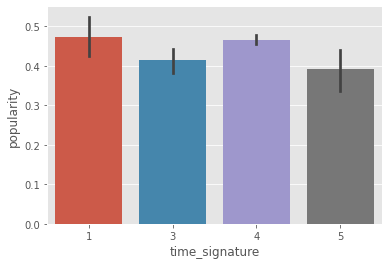

In [ ]:
sns.barplot(x = 'time_signature', y = 'popularity', data = playlist_tracks_df);

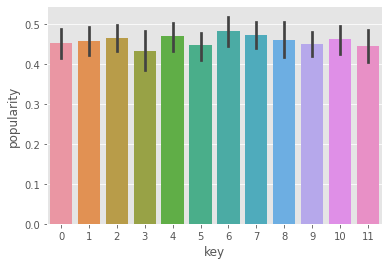

In [ ]:
sns.barplot(x = 'key', y = 'popularity', data = playlist_tracks_df);
#btw, all keys encoded as values ranging from 0 to 11, starting on C as 0, C# as 1 and so on…

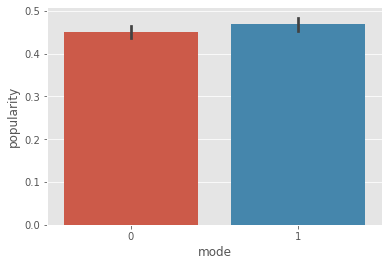

In [ ]:
sns.barplot(x = 'mode', y = 'popularity', data = playlist_tracks_df);
#0 mode = minor, 1 mode = major

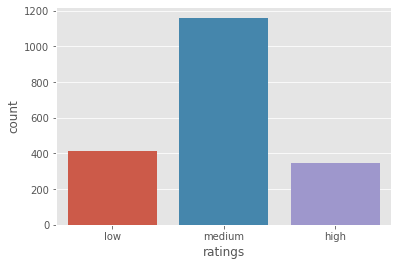

In [ ]:
sns.countplot(x = 'ratings', data = playlist_tracks_df);


# Bivariate Analysis Contd.

### key and mode are related in music, so let's combine them 


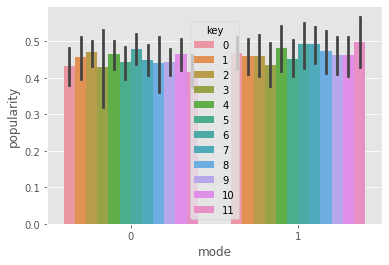

In [ ]:
sns.barplot(x = 'mode', y = 'popularity', hue = 'key', data = playlist_tracks_df);


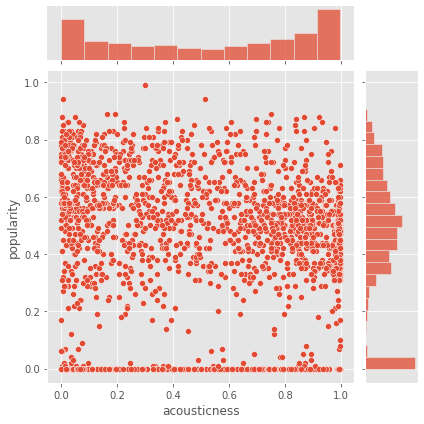

In [ ]:
sns.jointplot(x = 'acousticness', y = 'popularity', data = playlist_tracks_df);


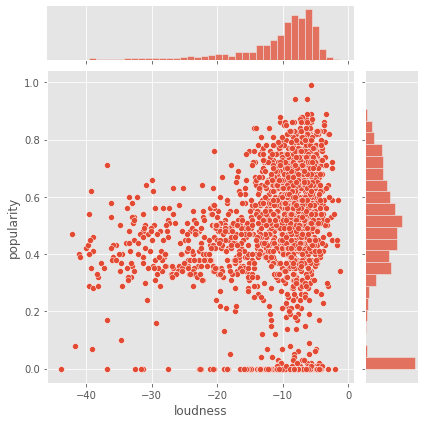

In [ ]:
sns.jointplot(x = 'loudness', y = 'popularity', data = playlist_tracks_df);

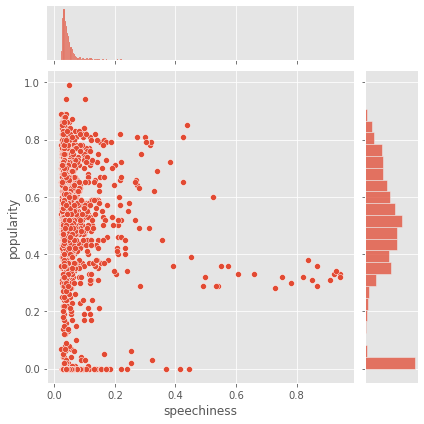

In [ ]:
sns.jointplot(x = 'speechiness', y = 'popularity', data = playlist_tracks_df);

/home/rohi/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


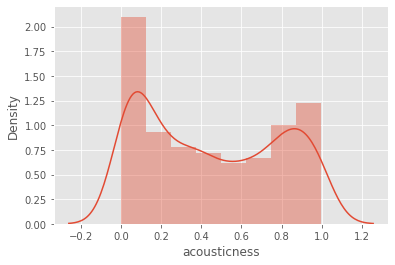

In [21]:
popular_greater_50 = playlist_tracks_df[playlist_tracks_df.popularity > .50]
sns.distplot(popular_greater_50['acousticness']);

/home/rohi/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


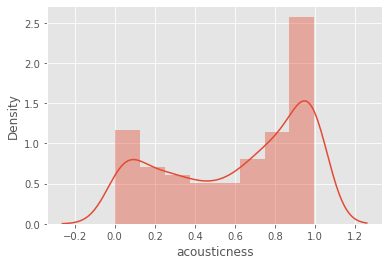

In [ ]:
popular_less_50 = playlist_tracks_df[playlist_tracks_df.popularity < .50]
sns.distplot(popular_less_50['acousticness']);

/home/rohi/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


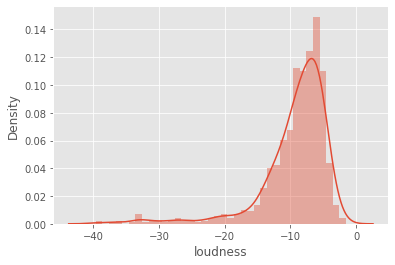

In [ ]:
sns.distplot(popular_greater_50['loudness']);

/home/rohi/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


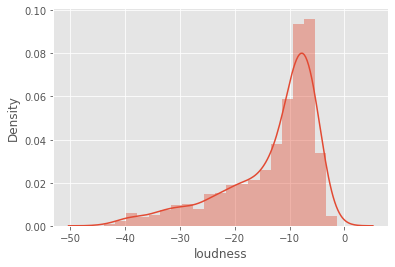

In [ ]:
sns.distplot(popular_less_50['loudness']);

### Lets change the duration to minutes and not milliseconds

In [24]:
playlist_tracks_df['duration_m'] = playlist_tracks_df['duration_ms']/60000
playlist_tracks_df = playlist_tracks_df.reindex(sorted(playlist_tracks_df.columns), axis=1)

In [25]:
playlist_tracks_df.drop('duration_ms', axis = 1, inplace = True)

In [26]:
playlist_tracks_df.describe()

,acousticness,album_tracks,danceability,disc_number,duration_m,energy,index,instrumentalness,key,liveness,loudness,mode,playlist_tracks,popularity,speechiness,tempo,time_signature,track_number,valence
count,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000,1922.000000
mean,0.536313,9.067118,0.549276,1.026535,3.915282,0.438012,986.174818,0.164251,5.314776,0.161969,-11.411185,0.518730,165.259625,0.459740,0.063970,116.706581,3.892300,3.710718,0.403920
std,0.349434,11.456191,0.157510,0.345753,1.491922,0.251132,576.381581,0.338752,3.495409,0.126655,7.444936,0.499779,100.053373,0.231597,0.088824,30.758960,0.441653,4.086847,0.230817
min,0.000042,1.000000,0.061600,1.000000,0.714450,0.000436,3.000000,0.000000,0.000000,0.027600,-43.851000,0.000000,4.000000,0.000000,0.022400,48.245000,1.000000,1.000000,0.033600
25%,0.187000,1.000000,0.441250,1.000000,3.187654,0.238000,483.250000,0.000000,2.000000,0.096300,-13.252750,0.000000,100.000000,0.360000,0.032800,92.198750,4.000000,1.000000,0.216500
50%,0.581500,9.000000,0.561000,1.000000,3.703050,0.448000,988.500000,0.000006,5.000000,0.115000,-8.856500,1.000000,126.000000,0.490000,0.041200,114.177000,4.000000,2.000000,0.371500
75%,0.867750,13.000000,0.666000,1.000000,4.310150,0.632750,1488.750000,0.009325,9.000000,0.172000,-6.522750,1.000000,300.000000,0.620000,0.056875,136.856000,4.000000,5.000000,0.562000
max,0.996000,204.000000,0.963000,11.000000,26.361333,0.994000,1987.000000,0.978000,11.000000,0.959000,-1.266000,1.000000,300.000000,0.990000,0.944000,206.297000,5.000000,43.000000,0.978000


/home/rohi/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


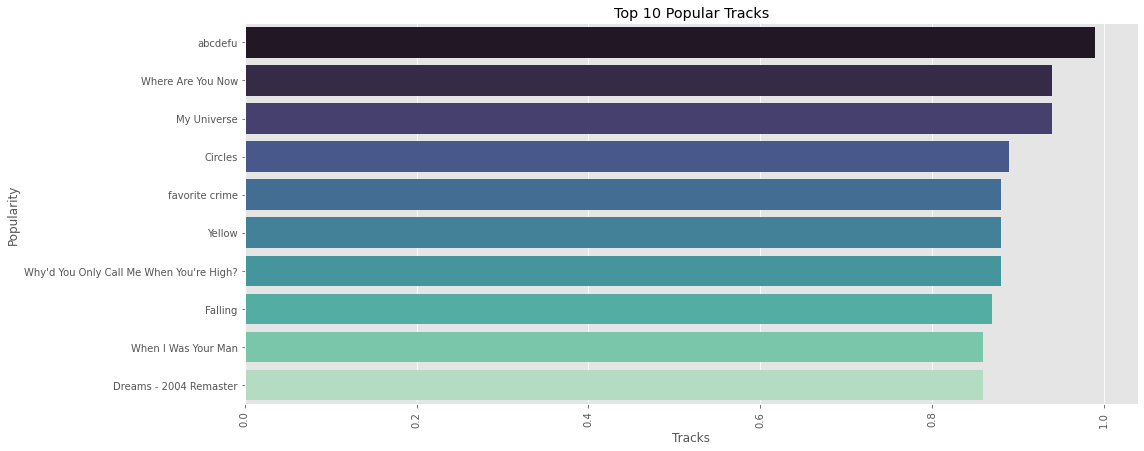

In [ ]:
#Most Popular Tracks
fig, axis = plt.subplots(figsize = (16,7))
popular = playlist_tracks_df.groupby("name")['popularity'].mean().sort_values(ascending=False).head(10)
axis = sns.barplot(popular,popular.index,palette="mako",orient = 'h')
axis.set_title('Top 10 Popular Tracks')
axis.set_ylabel('Popularity')
axis.set_xlabel('Tracks')
plt.xticks(rotation = 90);

/home/rohi/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


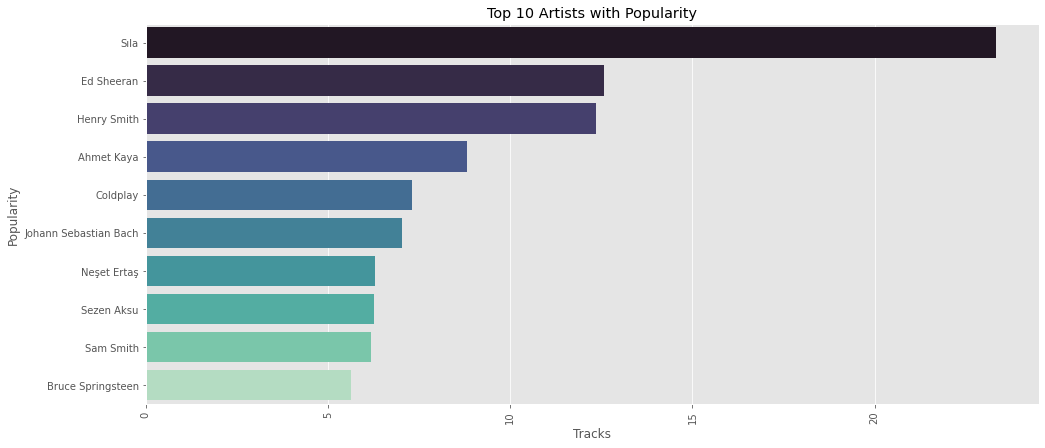

In [ ]:
#Most Popular Artists
fig, axis = plt.subplots(figsize = (16,7))
popular = playlist_tracks_df.groupby("artist_name")['popularity'].sum().sort_values(ascending=False)[:10]
axis = sns.barplot(popular,popular.index,palette="mako",orient = 'h')
axis.set_title('Top 10 Artists with Popularity')
axis.set_ylabel('Popularity')
axis.set_xlabel('Tracks')
plt.xticks(rotation = 90);

# Multivariate Analysis

Lets start with a pairplot to visualize whether there are any outliers in the variables

In [ ]:
# sns.pairplot(playlist_tracks_df);

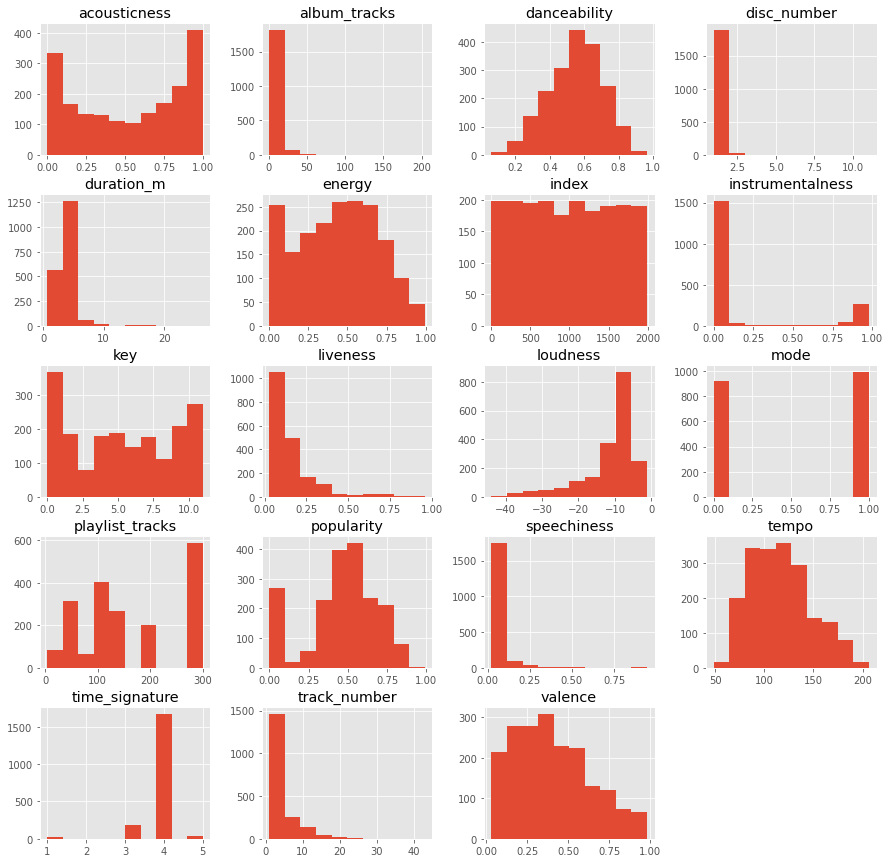

In [ ]:
playlist_tracks_df.hist(figsize=(15, 15))
plt.show()

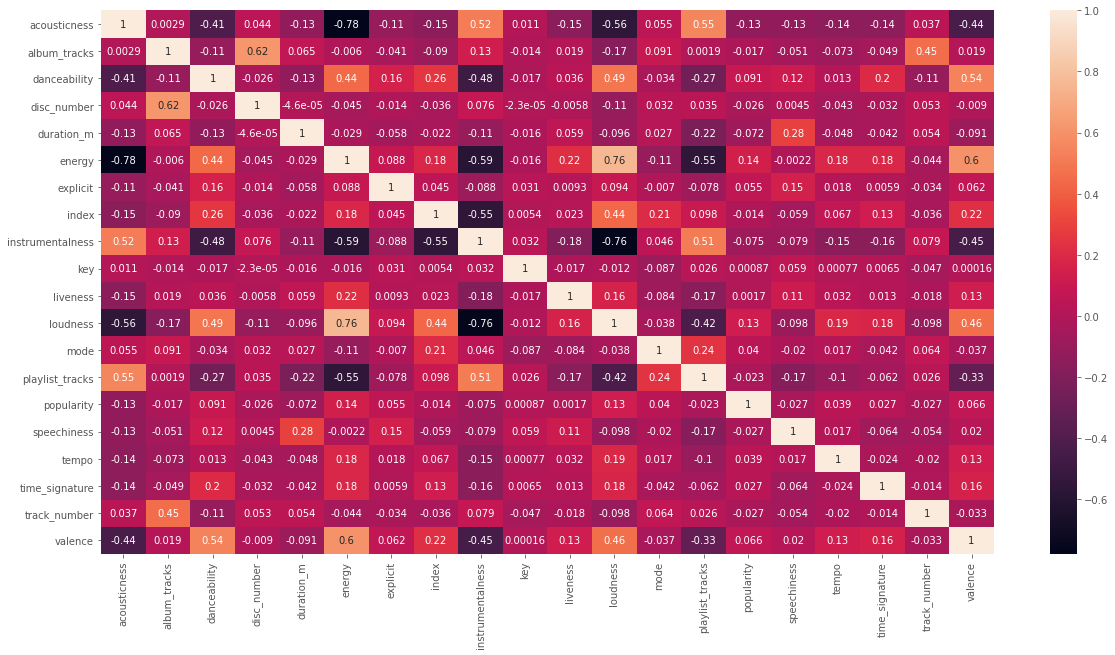

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(playlist_tracks_df.corr(),annot = True);

# Modelling and Predcitions

# Trial 1: Regression Tasks.

## 1. Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [ ]:
playlist_tracks_df.head(10)

,acousticness,added_at,added_by,album_artist_id,album_artist_name,album_genres,album_id,album_name,album_release_date,album_tracks,...,popularity,ratings,speechiness,tempo,time_signature,track_href,track_number,type,uri,valence
0,0.279,2021-07-30T17:57:53Z,{'external_urls': {'spotify': 'https://open.sp...,3WKZeiNOV5dnANlQnjL95B,Irmak Arıcı,"[turkish pop, turkish trap pop]",0Djqo0rhYBbRpIFEZbzEqQ,Güya,2021-03-19,1,...,0.50,medium,0.2120,171.936,4,https://api.spotify.com/v1/tracks/5eattTP6wBD7...,1,audio_features,spotify:track:5eattTP6wBD7BN8KtKt7gO,0.733
1,0.709,2021-07-30T17:58:03Z,{'external_urls': {'spotify': 'https://open.sp...,2xNgzwX6A9orF0QEJph5Eb,Kerim Araz,[turkish trap pop],7cMKfAygL40oApyrkCrwmz,Toparlanmam Lazım,2021-07-13,1,...,0.48,medium,0.0392,129.909,4,https://api.spotify.com/v1/tracks/7tQzRtcodzeV...,1,audio_features,spotify:track:7tQzRtcodzeVr6n0DdVHCe,0.371
2,0.283,2021-07-30T17:58:13Z,{'external_urls': {'spotify': 'https://open.sp...,3cNwyF5SboOs9icz2XyotE,Mustafa Ceceli,"[karadeniz pop, turkish pop, turkish trap pop]",4NAFZH7smr9G2SP4U8stRX,Gün Ağarmadan,2020-06-12,1,...,0.44,medium,0.0548,159.707,4,https://api.spotify.com/v1/tracks/12Df1GI1bZGH...,1,audio_features,spotify:track:12Df1GI1bZGHG5l0PvvxRc,0.151
3,0.102,2021-07-30T17:58:32Z,{'external_urls': {'spotify': 'https://open.sp...,07eC5PcqS4O5e6NX1mrSCZ,Eri Qerimi,[],6uhwxyEzfgoyv6yJJHdoxQ,RRAK TAK TAK (Remix),2021-06-11,1,...,0.29,low,0.0484,92.990,4,https://api.spotify.com/v1/tracks/7aI1YkyFmJtB...,1,audio_features,spotify:track:7aI1YkyFmJtB2OvI1dF2o7,0.613
4,0.747,2021-07-30T17:58:54Z,{'external_urls': {'spotify': 'https://open.sp...,1Y2FwScblyMxpLTrNdfwyU,Ahmet Kaya,[turkish folk],27dDxMGawvjeKQ2aYWfPRI,Dosta Düşmana Karşı,1998-03-06,12,...,0.63,medium,0.0348,108.973,4,https://api.spotify.com/v1/tracks/1RMnFV3jidSA...,3,audio_features,spotify:track:1RMnFV3jidSADH1ZSF8EAr,0.512
5,0.846,2021-07-30T17:59:03Z,{'external_urls': {'spotify': 'https://open.sp...,1Y2FwScblyMxpLTrNdfwyU,Ahmet Kaya,[turkish folk],27dDxMGawvjeKQ2aYWfPRI,Dosta Düşmana Karşı,1998-03-06,12,...,0.62,medium,0.0306,97.983,4,https://api.spotify.com/v1/tracks/4D6TKXvFTktp...,9,audio_features,spotify:track:4D6TKXvFTktph6Vj6Pi1IC,0.774
6,0.719,2021-07-30T17:59:19Z,{'external_urls': {'spotify': 'https://open.sp...,2NGRETzxjeN4b9o3OGY6Yn,Selda Bağcan,"[anadolu rock, azeri traditional, turkish folk...",32YFmtwnFHEiNam28vmaqs,Dost Merhaba,1986-11-26,12,...,0.62,medium,0.0299,110.079,4,https://api.spotify.com/v1/tracks/2lN6njvQIWp5...,4,audio_features,spotify:track:2lN6njvQIWp5ZSFzmAME5k,0.364
7,0.851,2021-07-30T17:59:28Z,{'external_urls': {'spotify': 'https://open.sp...,1Y2FwScblyMxpLTrNdfwyU,Ahmet Kaya,[turkish folk],62K3eu3Wi048LiX5POSemY,Sevgi Duvarı,1990,10,...,0.56,medium,0.0368,159.484,3,https://api.spotify.com/v1/tracks/37UtxZlR7UXM...,9,audio_features,spotify:track:37UtxZlR7UXMInXGgauHzT,0.545
8,0.685,2021-07-30T17:59:34Z,{'external_urls': {'spotify': 'https://open.sp...,1Y2FwScblyMxpLTrNdfwyU,Ahmet Kaya,[turkish folk],2qomyrkuvwWPYxo2QRQd3d,Yorgun Demokrat,1987,12,...,0.60,medium,0.0384,113.575,4,https://api.spotify.com/v1/tracks/5l30dKaCPIsv...,1,audio_features,spotify:track:5l30dKaCPIsv6vuUg1l8xm,0.275
9,0.751,2021-07-30T17:59:46Z,{'external_urls': {'spotify': 'https://open.sp...,1Y2FwScblyMxpLTrNdfwyU,Ahmet Kaya,[turkish folk],0uESCKuRsQ2qzuzXV2FP9T,Yıldızlar Ve Yakamoz,1997-02-19,11,...,0.54,medium,0.0297,110.000,4,https://api.spotify.com/v1/tracks/0P17U8ZE1woH...,1,audio_features,spotify:track:0P17U8ZE1woH2rRAMRwOqq,0.464


In [ ]:
features = playlist_tracks_df.columns
X = playlist_tracks_df.drop(columns=['popularity'])
y = playlist_tracks_df['popularity']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# features2 = ['duration_ms', 'disc_number', 'track_number', 'album_tracks', 'playlist_tracks']
features2 = ['acousticness', 'instrumentalness', 'loudness', 'energy']
X_train, X_test, y_train, y_test = train_test_split(X[features2], y, train_size=0.5, random_state=8)


In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.012354347321597792

In [ ]:
print(lr.intercept_)
print(lr.coef_)
zip(features, lr.coef_)

0.47408110925691077
[-0.00735626  0.04453018  0.0045957   0.06494888]


In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
from sklearn import metrics
from sklearn.metrics import r2_score
print(metrics.r2_score(y_test, y_pred))
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.012354347321597792
0.1772379663226095
0.053134191604793435
0.2305085499602855


 # Auto ML

## Compare all the Regression Algorithms using Pycaret

- Pycaret is an outstanding package that tries to compare all machine learning regression algorithms and automatically ranks the best perfroming algorithm based on MAE, MSE, RMSE, $R^2$, RMSLE, MAPE, and TT(Sec)

In [ ]:
# !pip install pycaret

In [ ]:
import pycaret
from pycaret.regression import setup, compare_models,\
     create_model, tune_model, predict_model,interpret_model, plot_model
print('PyCaret: %s' % pycaret.__version__)

PyCaret: 2.3.5


In [ ]:
# # configure pycaret by downgrading scikit-learn
# !conda config --append channels conda-forge
# !conda install scikit-learn=0.23.2
# pip install catboost

Lets sample the data in 500, 1000, 1500 and the full dataset as we compare how models perform

In [27]:
spotify_sample500 = playlist_tracks_df.sample(500)
spotify_sample1000 = playlist_tracks_df.sample(1000)
spotify_sample1500 = playlist_tracks_df.sample(1500)
spotify_full = playlist_tracks_df.sample(len(playlist_tracks_df))

### setup your regression parameters 

In [ ]:
regression = setup(data =  spotify_sample500,
 target = 'popularity'
 )

,Description,Value
0,session_id,1248
1,Target,popularity
2,Original Data,"(500, 41)"
3,Missing Values,False
4,Numeric Features,12
5,Categorical Features,26
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(349, 210)"


### Comparing Models

In [ ]:
compare_models(['dt','rf','xgboost', 'svm'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0748,0.0084,0.0912,0.8367,0.0688,0.2321,0.4460
xgboost,Extreme Gradient Boosting,0.0787,0.0100,0.0996,0.8062,0.0758,0.2525,26.4400
dt,Decision Tree Regressor,0.0936,0.0160,0.1258,0.6926,0.0964,0.2877,0.5300
svm,Support Vector Regression,0.1756,0.0559,0.2355,-0.0459,0.1784,1.0094,0.0310


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=1248, verbose=0, warm_start=False)

### Create the best model

In [ ]:
rf = create_model('rf')


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0696,0.0080,0.0892,0.8706,0.0689,0.2054
1,0.0752,0.0074,0.0857,0.8362,0.0639,0.1566
2,0.0885,0.0113,0.1065,0.7423,0.0798,0.2167
3,0.0768,0.0081,0.0902,0.8196,0.0670,0.2770
4,0.0669,0.0078,0.0881,0.8547,0.0683,0.1759
5,0.0766,0.0085,0.0921,0.8385,0.0706,0.2956
6,0.0598,0.0058,0.0761,0.9152,0.0597,0.1781
7,0.0780,0.0088,0.0939,0.8100,0.0705,0.2608
8,0.0700,0.0069,0.0832,0.8998,0.0575,0.3354
9,0.0869,0.0115,0.1073,0.7803,0.0822,0.2196


### Tune the model

In [ ]:
tune_model(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0657,0.0080,0.0896,0.8696,0.0692,0.2032
1,0.0765,0.0089,0.0944,0.8016,0.0687,0.1775
2,0.0880,0.0114,0.1069,0.7404,0.0815,0.2235
3,0.0794,0.0093,0.0963,0.7942,0.0735,0.3224
4,0.0659,0.0079,0.0890,0.8516,0.0694,0.1935
5,0.0758,0.0094,0.0969,0.8214,0.0741,0.1896
6,0.0618,0.0058,0.0764,0.9144,0.0573,0.1509
7,0.0681,0.0079,0.0890,0.8294,0.0659,0.2004
8,0.0666,0.0070,0.0836,0.8987,0.0572,0.1833
9,0.0883,0.0124,0.1115,0.7630,0.0864,0.2496


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=3, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0001,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=7, min_weight_fraction_leaf=0.0,
                      n_estimators=140, n_jobs=-1, oob_score=False,
                      random_state=1248, verbose=0, warm_start=False)

### Make predictions on test set

In [ ]:
predictions = predict_model(rf)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0688,0.0068,0.0825,0.8439,0.0604,0.1512


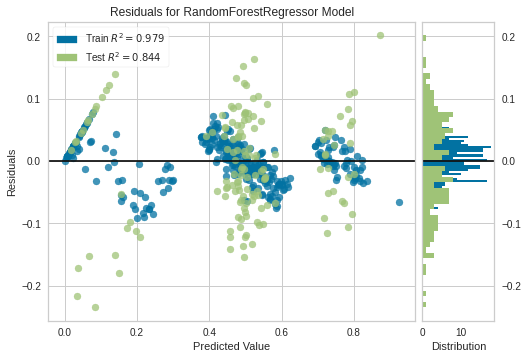

In [ ]:
# plotting a model
plot_model(rf)

### Interprete the model

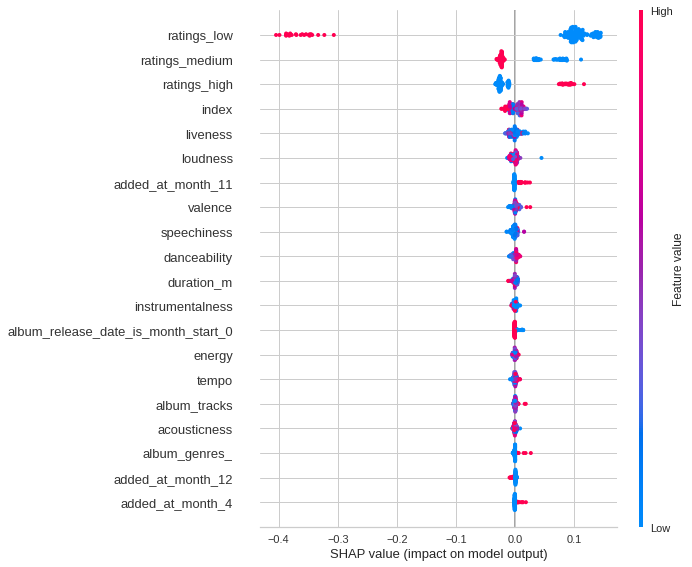

In [ ]:
interpret_model(rf)

# Trial 2: Classification Tasks.

### Train test splitting for the dataset


In [28]:
X = playlist_tracks_df[['popularity', 'explicit', 'duration_m', 'danceability', 'energy',
                        'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                        'liveness', 'valence', 'tempo', 'time_signature', 'genres']]  
y = playlist_tracks_df['ratings']

In [ ]:
y.value_counts()

medium    1161
low        415
high       346
Name: ratings, dtype: int64

### Class imbalance
From the preprocessing steps, we can see that the medium rating has the highest proportion compared with the other classes.
We need to do the balancing using oversampling and undersampling strategies.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

print('Removed indexes:')

print(X_ros.shape, y_ros.shape)

Removed indexes:
(3483, 16) (3483,)


In [ ]:
y_ros.value_counts()

low       1161
medium    1161
high      1161
Name: ratings, dtype: int64

### Fiting classification models using pycaret

In [30]:
import pycaret
from pycaret.classification import setup
from pycaret.classification import compare_models

In [31]:
grid = setup(data =  spotify_sample1000,
 target = 'ratings',
 fix_imbalance = True) # Smote sampling strategy.

,Description,Value
0,session_id,3636
1,Target,ratings
2,Target Type,Multiclass
3,Label Encoded,"high: 0, low: 1, medium: 2"
4,Original Data,"(1000, 41)"
5,Missing Values,False
6,Numeric Features,13
7,Categorical Features,25
8,Ordinal Features,False
9,High Cardinality Features,False


In [32]:
# evaluate models and compare models
best = compare_models(['dt','rf','xgboost', 'svm'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.6180
xgboost,Extreme Gradient Boosting,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,23.2110
rf,Random Forest Classifier,0.9357,0.9807,0.9076,0.9385,0.9346,0.8802,0.8835,0.4380
svm,SVM - Linear Kernel,0.4334,0.0000,0.3605,0.4779,0.3636,0.0388,0.0599,0.1870


### Create the model

In [33]:
from pycaret.classification import create_model
dt = create_model(best)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


### Hyperparameter Tuning

In [34]:
from pycaret.classification import tune_model
tune_model(dt)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=2, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.002, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=3636, splitter='best')

### Make Predictions

In [36]:
from pycaret.classification import predict_model
predictions = predict_model(dt)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


### Plot the Model

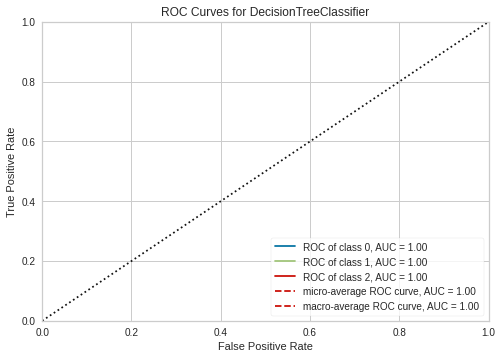

In [37]:
from pycaret.classification import plot_model
plot_model(dt)

### Interpret the model

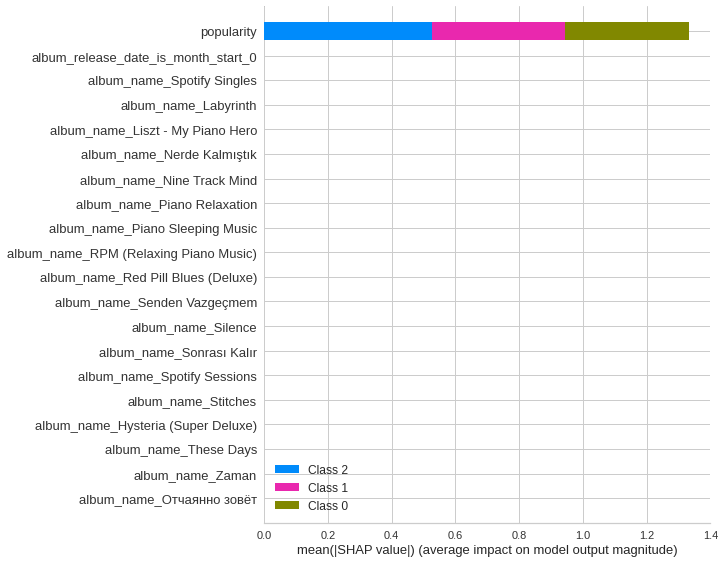

In [ ]:
from pycaret.classification import interpret_model
interpret_model(dt)

# Conclusion
Predictive analytics may be an overwhelming task, but with the rise of packages such as Pycaret, it looks like a simplified thing to work on. With just few lines of code after preprocessing data, modeling becomes a very easy task even for a newbie to handle. 

80% of the time was used in data acquisition, cleaning and preprocessing wheres only 20% was used for modeling. The whole procedure involded the following steps.
```
- Importing required libraries
- Scraping the data
- Data cleaning and data preprocessing
- seting up the model
- comparing the models
- pick and creating the best model
- predictions using the best model
- intepret feature importance

```